# Features nécessaires et attentes
- Entrainer un modèle pour prévoir la sévérité d'un cyclone tropical basé sur une entrée de données géographiques.
- La sévérité à prévoir se trouve dans la colonne "TD9636_STAGE" du dataset.
- Suivre les étapes d'un pipelining de Machine Learning pour déployer une application, qui prendra des coordonnées en input et retournera la sévérité du cyclone

In [1]:
#putting the notebook offline for ploting
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

# Premiers pas dans le Dataset
Après ouverture du fichier csv avec Excel, nous pouvons dors et déjà constater certains points :
- La colonne ISO_TIME ne comporte pas de données manquantes, elle est conçue à la manière d'une frise, c'est une time line
- Notre colonne target à analyser comporte elle de nombreux manques. En effet, ce sont des relevés d'une balise lors d'un orage. Comme les orages ne sont pas continus, il y a évidemment des moments sans mesures.
- Les valeurs de notre target étant une liste de cas possible, le modèle de la multiclass classification semble se dessiner.
- Les colonnes TD9636_LON et TD9636_LAT sont les coordonnées géographiques des relevés de la balise TD9636. Ces colonnes seront les features de notre modèle. Elles comportent des données manquantes, de la même manière que dans notre colonne target, lorsque la balise n'effectue pas de relevés.


In [2]:
#importing the the raw dataset with pandas + skip the unit row (1st under the head, because unreleavant) + low_memory False to avoid mixed types values
import pandas as pd
imported_csv = pd.read_csv("ibtracs.csv", skiprows = [1], low_memory=False) 
print(imported_csv)

#description of the dataset
print(imported_csv.head())
print(imported_csv.describe())
print(imported_csv.info())

                  SID  SEASON  NUMBER BASIN SUBBASIN     NAME  \
0       1980001S13173    1980       1    SP       MM     PENI   
1       1980001S13173    1980       1    SP       MM     PENI   
2       1980001S13173    1980       1    SP       MM     PENI   
3       1980001S13173    1980       1    SP       MM     PENI   
4       1980001S13173    1980       1    SP       MM     PENI   
...               ...     ...     ...   ...      ...      ...   
297093  2024280N18146    2024      72    WP       MM  BARIJAT   
297094  2024280N18146    2024      72    WP       MM  BARIJAT   
297095  2024280N18146    2024      72    WP       MM  BARIJAT   
297096  2024280N18146    2024      72    WP       MM  BARIJAT   
297097  2024280N18146    2024      72    WP       MM  BARIJAT   

                   ISO_TIME NATURE   LAT    LON  ... BOM_GUST_PER  \
0       1980-01-01 00:00:00     TS -12.5  172.5  ...                
1       1980-01-01 03:00:00     TS -12.2  172.4  ...                
2       1980

# Début d'Analyse
Nous voyons ici que la plupart des données sont en réalité des données manquantes. Dans le Dataset, elles étaient formulées sous forme d'espaces. Nous devons donc concentrer notre analyse sur les données que nous avons. 
La description du Dataset nous indique que notre target est composée de valeurs qui sont des relevés d'intensité des orages a un instant et une location donné, sur une échelle de 0 à 7. La valeur 7 est particulièrement intéressante car elle recoupe les données corrompues ou non identifiables. Il serait judicieux de tranformer nos données manquestes en 7 afin de les considérer comme données corrompues.

Lors du traitement des données il est également important de se charger d'unifier les différentes colonnes pertinentes à notre analyse: 
- ISO_TIME : important car un orage évolue au cours du temps. La manipulation de cette colonne sera beacoup plus efficace au format .datetime()
- TD9636_STAGE : notre target, int pour le moment, cela semble ok
- TD9636_LON : coordonnées de longitude, en float - l'autre feature
- TD9636_LAT : coordonnées de latitude, en float - un des feature

In [3]:
#The column we want to predict is TD9636_STAGE, lets take a look at it
print(type(imported_csv['TD9636_STAGE']))
print(imported_csv["TD9636_STAGE"].values)
print(imported_csv["TD9636_STAGE"].describe())
print(imported_csv.TD9636_STAGE.unique())
print(imported_csv.TD9636_STAGE.value_counts())

<class 'pandas.core.series.Series'>
['1' '1' '1' ... ' ' ' ' ' ']
count     297098
unique         8
top             
freq      248755
Name: TD9636_STAGE, dtype: object
['1' '2' '4' ' ' '0' '6' '5' '3']
TD9636_STAGE
     248755
2     17204
1     16028
4     10623
0      3156
3       742
5       331
6       259
Name: count, dtype: int64


In [4]:
#try indentifying missing values
print(imported_csv["TD9636_STAGE"].isnull().sum())

#there is no missing value in the target column. Indeed the missing value is a space, lets filter the data set by omitting " " in the values
#filtered_csv = imported_csv[imported_csv["TD9636_STAGE"] !=" "]
#filtered_csv = imported_csv.dropna(subset=["TD9636_STAGE"])

#not the good method, instead, we want to replace the " " by the value "7"
filtered_csv = imported_csv.copy()
filtered_csv["TD9636_STAGE"] = filtered_csv["TD9636_STAGE"].replace(" ", "7")
#suggestion in case we have the following values " " : utilisation de regex pour " " "" "\n" "\t"
#filtered_csv["TD9636_STAGE"].replace(r"^\s*$", "7", regex=True, inplace=True)
print(filtered_csv.TD9636_STAGE.unique())

#convert the target into float type pour utilisation sur la HeatMap | Optimisation to plan (le faire au moment du filtering)
filtered_csv["TD9636_STAGE"] = filtered_csv["TD9636_STAGE"].astype(float)

#need to identify how the LON and LAT are handled
print(filtered_csv["TD9636_LON"].dtype)
print(filtered_csv["TD9636_LAT"].dtype)

#convert object to float(coordinates)
filtered_csv["TD9636_LAT"] = pd.to_numeric(filtered_csv["TD9636_LAT"], errors="coerce")
filtered_csv["TD9636_LON"] = pd.to_numeric(filtered_csv["TD9636_LON"], errors="coerce")
print(filtered_csv["TD9636_LON"].dtype)
print(filtered_csv["TD9636_LAT"].dtype)

#handling Nan in coordinates
print(filtered_csv[["TD9636_LON", "TD9636_LAT"]].isna().sum())
filtered_csv = filtered_csv.dropna(subset=["TD9636_LAT", "TD9636_LON"])
print(filtered_csv[["TD9636_LON", "TD9636_LAT"]].isna().sum())
print(filtered_csv["TD9636_LON"].dtype)

#convertir ISO TIME
filtered_csv["ISO_TIME"] = pd.to_datetime(filtered_csv["ISO_TIME"])
print(filtered_csv["ISO_TIME"].dtype)

0
['1' '2' '4' '7' '0' '6' '5' '3']
object
object
float64
float64
TD9636_LON    249797
TD9636_LAT    249797
dtype: int64
TD9636_LON    0
TD9636_LAT    0
dtype: int64
float64
datetime64[ns]


# Analyse Univariée de la Target "TD9636_STAGE"
La répartiton des valeurs dans notre colonne STAGE montre que nous avons beacoup plus fréquemment des orages d'intensité de 1 et 2, en effet plus de 67 % des données sont enregistrées dans cette plage.
Cepedant la nature même du Dataset nous pousse vers une analyse bivariée beacoup plus rapidement. En effet le facteur temps et géographique doiventt impérativement entrer en compte.
La colonne BASIN, indiquant le bassin géographique ou à eu lieu la tempête est utilisé comme condition dans l'histograme.

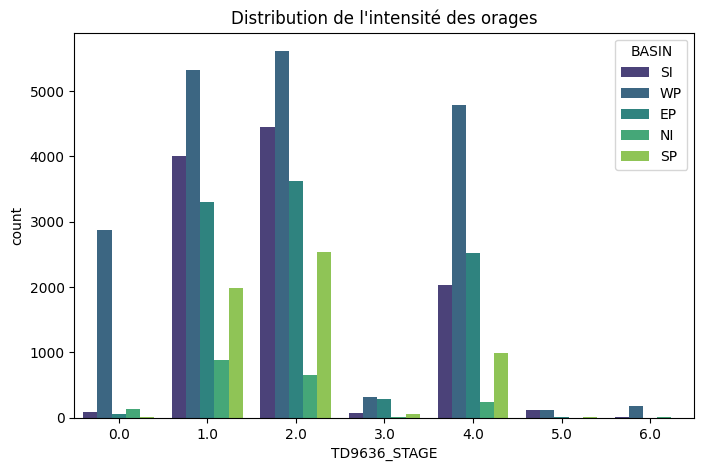

On the Data we have 47301 values that has a point to analyse. Among them, the repartition is at is follow 
 TD9636_STAGE
2.0    16887
1.0    15503
4.0    10587
0.0     3152
3.0      742
5.0      243
6.0      187
Name: count, dtype: int64 
 Wich gives in percentage TD9636_STAGE
2.0    35.701148
1.0    32.775206
4.0    22.382191
0.0     6.663707
3.0     1.568677
5.0     0.513731
6.0     0.395340
Name: count, dtype: float64


In [5]:
#Analyse univariée de notre target
from matplotlib import pyplot as plt
import seaborn as sns

#assez basique celui du dessous est plus joli
#sns.histplot(filtered_csv["TD9636_STAGE"])
#plt.title("Distribution de l'intensité des orages")
#plt.show()

#Tel quel, le box plot n'est pas pertinent
#sns.boxplot(x=filtered_csv['TD9636_STAGE'])
#plt.title("Boxplot de l'intensité des orages")
#plt.show()

#distribution des classes
plt.figure(figsize=(8,5))
sns.countplot(x="TD9636_STAGE", data=filtered_csv, hue="BASIN", palette="viridis")
plt.title("Distribution de l'intensité des orages")
plt.show()

#compte de la répartition de l'intensité en pourcentage
total_intensité = len(filtered_csv[filtered_csv["TD9636_STAGE"] !=7])
nombre_intensités = filtered_csv["TD9636_STAGE"][filtered_csv["TD9636_STAGE"] !=7].value_counts()
print(f"On the Data we have {total_intensité} values that has a point to analyse. Among them, the repartition is at is follow \n {nombre_intensités} \n Wich gives in percentage {(nombre_intensités / total_intensité) * 100}")


# Analyse univariée des features _LON et _LAT de la balise TD9636
Jetons également un oeil sur les répartitions de LON et LAT
- Le box plot nous montre que la classe de l'équateur est très peu représentée, est que les relevés semblent très proches.

         TD9636_LAT    TD9636_LON
count  47301.000000  47301.000000
mean       4.860206     61.557183
std       17.438667    109.460767
min      -50.000000   -180.000000
25%      -13.600000     43.000000
50%       12.000000    114.000000
75%       17.800000    140.400000
max       49.000000    180.000000


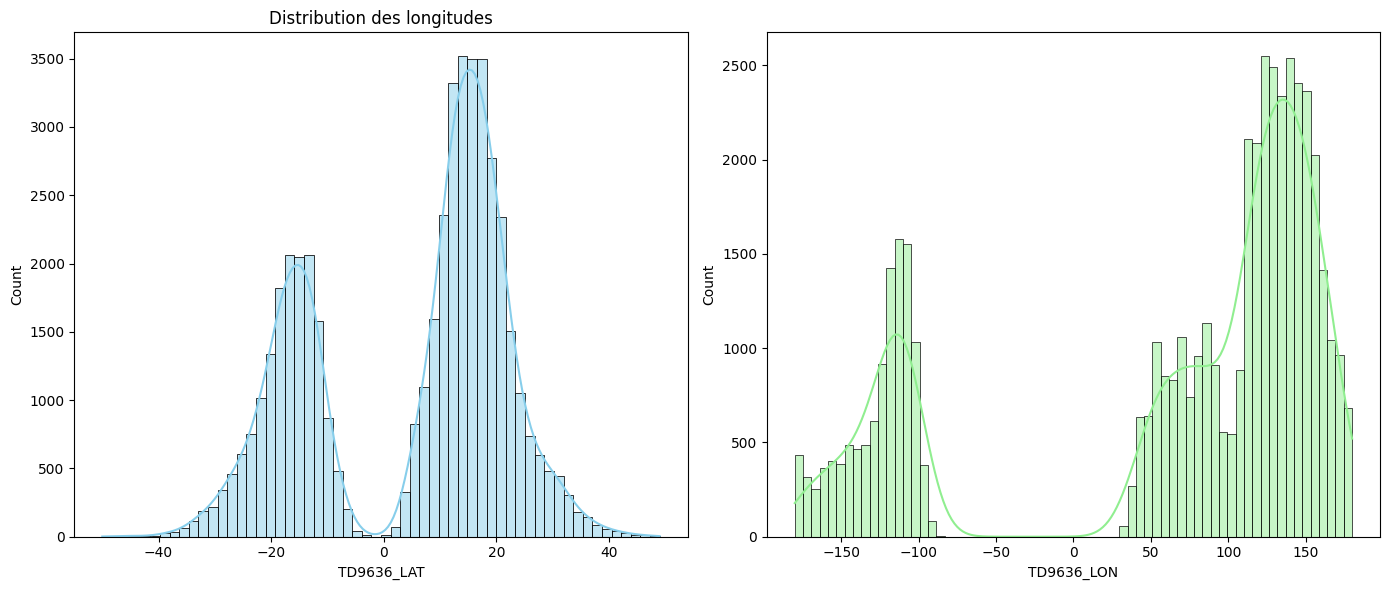

In [19]:
import plotly.express as px

#boxplot de la répartition de LON et LAT
print(filtered_csv[["TD9636_LAT", "TD9636_LON"]].describe())

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.histplot(filtered_csv["TD9636_LAT"], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution des latitudes")

sns.histplot(filtered_csv["TD9636_LON"], kde=True, ax=axes[1], color="lightgreen")
axes[0].set_title("Distribution des longitudes")

plt.tight_layout()
plt.show()

#plot sur une carte - CODE à faire marcher
#plot_features = px.scatter(filtered_csv, y="TD9636_LAT", x="TD9636_LON", size="TD9636_STAGE", color="TD9636_STAGE",
#                           hover_data=["TD9636_STAGE", "TD9636_LAT", "TD9636_LON", "ISO_TIME", "BASIN", "NATURE"],
#)
#plot_features.show

# Analyse des valeurs de ISO_TIME
Nous allons regarder ici sur quelle période de temps les relevés sont effectués et comment sont ils répartis

D'après le graphique, nous voyons que nous avons une répartition plutôt homogène entre 1980 et 1989, hormis deux années lors desquelles il y en a eu moins, 1983 et 1988.

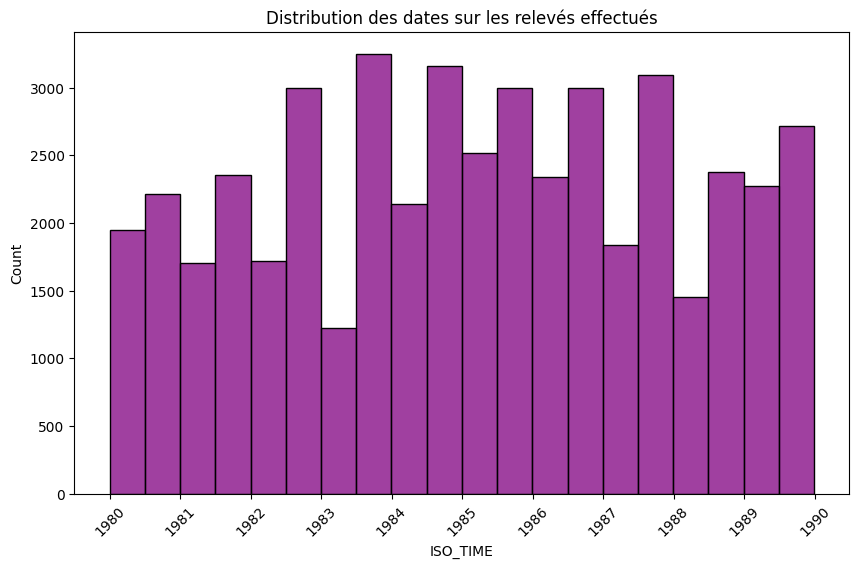

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_csv["ISO_TIME"], kde=False, color="purple", bins=20)
plt.title("Distribution des dates sur les relevés effectués")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Analyse de la répartition de l'intensité des orages par rapport aux bassins, avec comme condition les subbassins

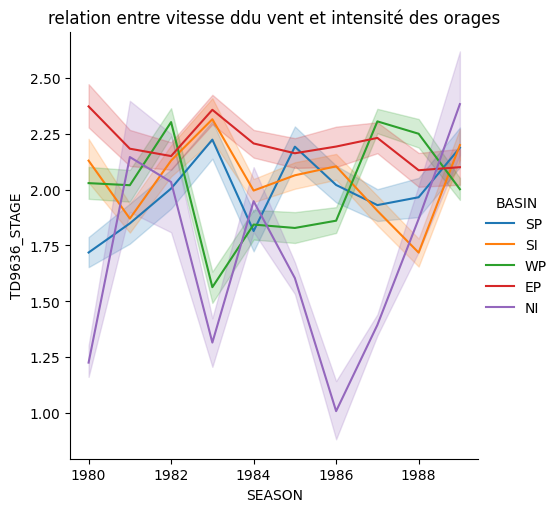

In [24]:
#Analyse univariée
#diagramme de répartition entre intensité de l'orage et vitesse du vent
sns.relplot(x="SEASON", y="TD9636_STAGE", data=filtered_csv, kind="line", hue="BASIN")
plt.title("relation entre vitesse ddu vent et intensité des orages")
plt.show()


# Analyse bivariée (géographie/target)

Nous allons essayer ici de voir les différentes relations qui peuvent exister entre les différentes colonnes.
Nous pouvons donc en profiter pour nous intéresser aux liens entre nos features et notre target.

Regardons tout d'abord les relations entre les coordonnées géographiques (_LON et _LAT) par rapport à notre target

Ce graphique complète notre précédente constatation sur la répartition géographique des orages. La répartition géographique reste similaire, peu importe l'intensité de la perturbation.


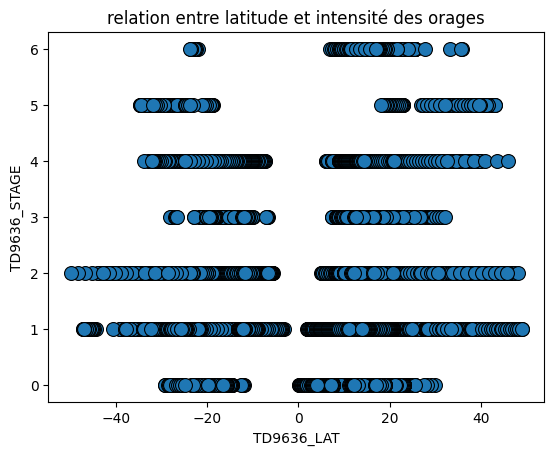

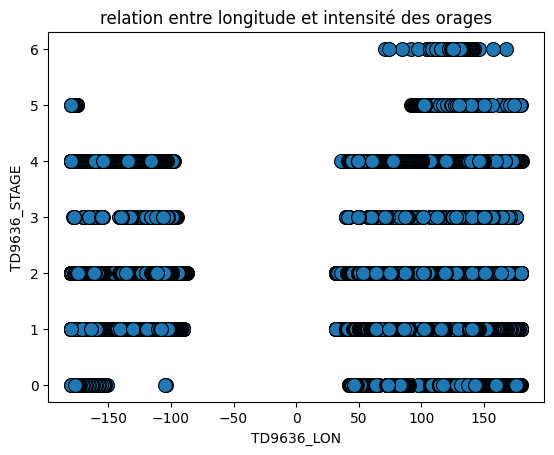

In [20]:
#Analyse bivariée
#diagramme de dispersion entre intensité et latitude
sns.scatterplot(x="TD9636_LAT", y="TD9636_STAGE", data=filtered_csv, s=100, edgecolor="black")
plt.title("relation entre latitude et intensité des orages")
plt.show()

#diagramme de dispersion entre longitude et intensité
sns.scatterplot(x="TD9636_LON", y="TD9636_STAGE", data=filtered_csv, s=100, edgecolor="black")
plt.title("relation entre longitude et intensité des orages")
plt.show()

# Relations statistiques Intensité (target) / Vitesse du vent
Lorsqu'un orage ou une tempête apparait, un phénomène naturel notable est la variation de la vitesse du vent. Des relevés ont été effectués de ces vitesses lors des relevés de notre balise TD9636.

### Nécessité de traiter les missing values dans la colonne TD9636_WIND


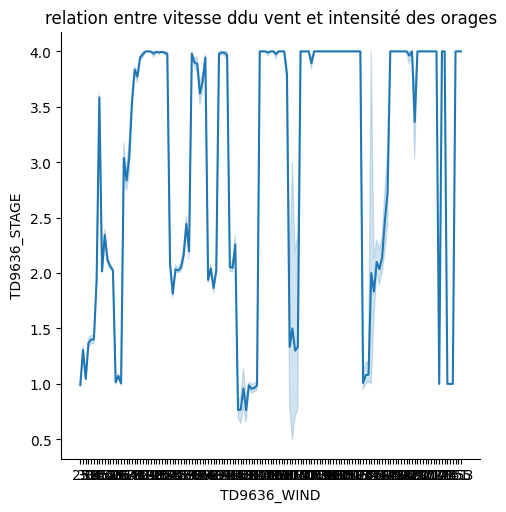

In [ ]:
#Analyse bivariée
#diagramme de répartition entre intensité de l'orage et vitesse du vent
sns.relplot(x="TD9636_WIND", y="TD9636_STAGE", data=filtered_csv, kind="line")
plt.title("relation entre vitesse ddu vent et intensité des orages")
plt.show()

#Les données manquantes dans la colonne nos empêche de percevoir la pertinence de ce graphique.

# Analyse Bivariée (variation temporelle target/ISO_TIME)
Nous allons ici regarder la variation temporelle de notre target

Nous observons ici une certaine redondance des relevés, en effet un schéma se met en place. Les moyennes de relevés sont plus hautes à cetaines périodes de l'année et de manière récurrente au fil des années. Il y a donc un phénomène saisonnier dans l'apparition des orages et tempêtes.

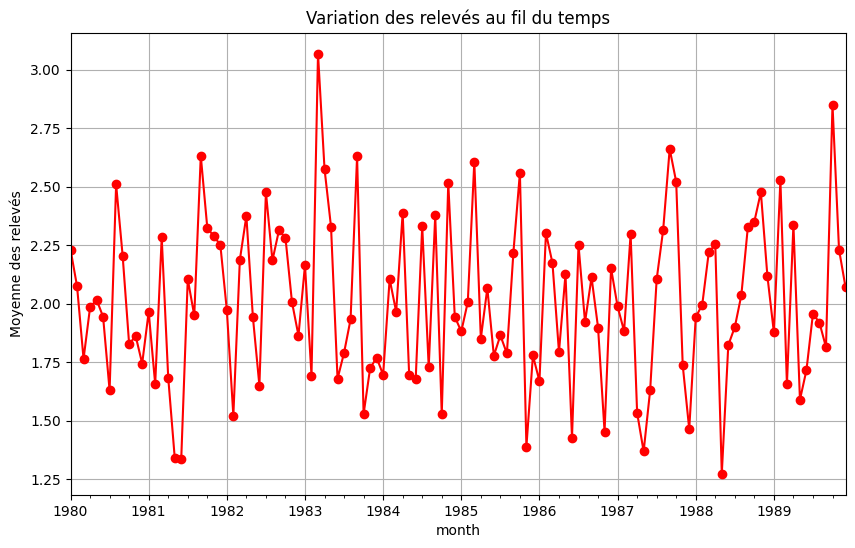

In [11]:
#Moyenne de target par mois pour éviter trop d'informations
filtered_csv["month"] = filtered_csv["ISO_TIME"].dt.to_period("M")

temporal_mean = filtered_csv.groupby('month')["TD9636_STAGE"].mean()

plt.figure(figsize=(10, 6))
temporal_mean.plot(kind="line", marker="o", color="red")
plt.title("Variation des relevés au fil du temps")
plt.ylabel("Moyenne des relevés")
plt.grid(True)
plt.show()


# Analyse Multivariée
La nature même du Dataset et les précédents relevés nous poussent à fair le rapprochement entre toutes nos variables précédemment étudiées.

Essayons tout d'abord une heatmap des données, nous voyons une relation linéaire entre les variables numériques.

Nous remarquons un uniformité dans la répartition des valeurs de la matrice. Nous pouvons donc supposer que l'apparition des orages peut s'établir shématiquement.

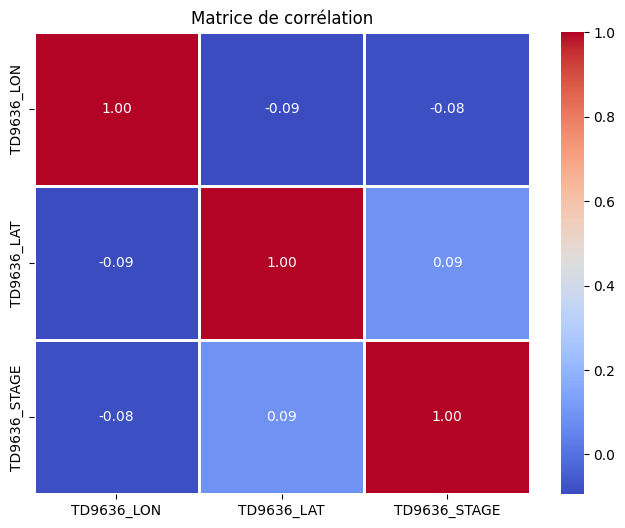

In [12]:
from mpl_toolkits.mplot3d import Axes3D

#Heatmap de la matrice de corrélation
corr = filtered_csv[["TD9636_LON", "TD9636_LAT", "TD9636_STAGE"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Matrice de corrélation")
plt.show()

# Analyse Spatiale de la distribution des relevés

- La carte est interractive. Il y a un slider sur le haut afin de définir la plage de date souhaitée. L'info-box à sa droite permet de saisir manuellement les dates de début et fin de la plage.
- La carte actualise les points en fonction de la plage sélectioonée (end-use note : depending on the pc spec. it may takes time).
- Les points sont reliées entre eux pour suivre l'itinéraire des orages, il ne sont reliés seulement si leur proximité est inférieure à 300km et que le relevé est fait moins de 48h avant (paramètres modifiables dans le code), afin d'éviter que les relevés ne se relient de manère non voulue.
- Les points sont également colorés en fonction de l'intensité de l'orage.
- Le mouseover des points permet d'afficher plus d'information. Cliquer dessus permet de fixer ces informations dans un popup.

### Features à prévoir sur plot spacial: 
possible optimisation du runtime, séparer les fonctions en package pour meilleur lisibilité du notebook


In [16]:
#Analyse géographique de l'intensité - avec folium carte interractive
import folium
from folium.plugins import MarkerCluster
import ipywidgets as widgets
from IPython.display import display
import branca.colormap as cm
from geopy.distance import geodesic



#Inside the TARGET column, the value 7 has no point to be in the map
filtered_csv = filtered_csv[filtered_csv["TD9636_STAGE"] !=7]

#création d'un slider et de ses limites pour ISO TIME
min_date, max_date = filtered_csv["ISO_TIME"].min(), filtered_csv["ISO_TIME"].max()

interractive_slider = widgets.SelectionRangeSlider(
    options=[date.strftime("%Y-%m-%d") for date in pd.date_range(min_date, max_date)],
    index=(0,len(pd.date_range(min_date, max_date)) - 1),
    description="Date Range",
    orientation="horizontal",
    layout={"width": "80%"}
)

#cration color map entre 0 et 6 pour la target
colormap = cm.linear.viridis.scale(0,6)

#possibilité de mettre à jour la carte en fonction de la plage de dates séléctionnée
def update_map(date_range):
    """
    Argument : la plage de date du slider
    retrun : la carte
    """

    start_date, end_date = pd.to_datetime(date_range)
    filtered_map = filtered_csv[(filtered_csv["ISO_TIME"] >= start_date) & (filtered_csv["ISO_TIME"] <= end_date)]

    #création de la map
    carte = folium.Map(location=[filtered_csv["TD9636_LAT"].mean(), filtered_csv["TD9636_LON"].mean()], zoom_start=5)
    
    #création du cluster de points et ajout des points from target
    map_cluster = MarkerCluster().add_to(carte)
    for _, row in filtered_map.iterrows():
        folium.CircleMarker(
            location=[row["TD9636_LAT"], row["TD9636_LON"]],
            radius=5,
            color=colormap(row["TD9636_STAGE"]),
            fill=True,
            fill_color=colormap(row["TD9636_STAGE"]),
            fill_opacity=0.8,
            popup=f"Date: {row["ISO_TIME"].date()}<br>Target: {row["TD9636_STAGE"]}", #info au clic de la souris
            tooltip=f"Date: {row["ISO_TIME"].date()}<br>Target: {row["TD9636_STAGE"]}<br>Location: {row["BASIN"]}<br>Nature: {row}" #info au mouseover
        ).add_to(map_cluster)
    
    #relier les points ajoutés pour une meilleure lisibilité, et dans l'ordre du temps
    filtered_map = filtered_map.sort_values("ISO_TIME")

    #coordinates = filtered_map[["TD9636_LAT", "TD9636_LON"]].values.tolist()
    #filtrer les lignes pour ne connecter que les points proches (attention pour v1 avec 1 seul filtre, remplacer nom de la fonction et le 1er paramètre par la var coordinates)
    filtered_lines = filter_close_points_with_time(filtered_csv, max_distance_km=300)

    #ajouter les segments filtrés
    for segment in filtered_lines:
        folium.PolyLine(segment, color="blue", weight=2.5, opacity=0.7).add_to(carte)

    #ajout d'une légende
    colormap.caption = "TD9636 Value"
    carte.add_child(colormap)

    return carte

#fonction d'affichage interractif
def interractive_map(date_range):
    display(update_map(date_range))

#de part l'immense taille du data set et éviter qu'il y ait trop de points reliés pour rien, on va ajouter une fonction pour créer un seuil qui ne connectera que les points proches

#def filter_close_points(coords, max_distance_km=300):
    """
    argument : coords = tupple de [LAT et LON], max km (float) for the max distance
    returns list of list of segments to draw
    """
    #V1 avec un seul filtre par distance, remplacer le paramètre de la fonction par coords (pour matcher avec la boucle)
    #line = []
    #previous_point = None

    #for points in coords:
    #    if previous_point:
    #        distance = geodesic(previous_point, points).km #calcul de la distance en km
    #        if distance < max_distance_km: #test pour vérifier la distance
    #            line.append([previous_point, points])
    #    previous_point = points #update of the value of the previous point

    #return line

#Afin d'éviter que la segmentation ne relie deux points proches en distance mais pas en ISO_TIME, on ajoute un nouveau filtre
def filter_close_points_with_time(filtered_csv, max_distance_km=300, max_time_diff_hours=48):
    
    lines = []

    #Sort ISO_TIME to iterate in a chronological order, and create a new index from this sorting to avoid any index conflict
    filtered_csv = filtered_csv.sort_values("ISO_TIME").reset_index(drop=True)

    #goal is to go in the points of the DF to see 1. if they are close by Geographically 2. if they are close by in the Timeline
    for i in range(len(filtered_csv) - 1): #iterate until the penultiem element to compare each element with the previous one
        point1 = (filtered_csv.loc[i, "TD9636_LAT"], filtered_csv.loc[i, "TD9636_LON"]) #access the LAT and LON at i point
        point2 = (filtered_csv.loc[i + 1, "TD9636_LAT"], filtered_csv.loc[i + 1, "TD9636_LON"]) #access the LAT and LON at i+1 point, gives two successive points

        time_diff = (filtered_csv.loc[i + 1, "ISO_TIME"] - filtered_csv.loc[i, "ISO_TIME"]).total_seconds() / 3600 #the operation return a timedelta, .total_second convert into seconds, and /3600 for hours
        distance = geodesic(point1, point2).km #function to mesure a distance between 2 points, in km

        if distance < max_distance_km and time_diff < max_time_diff_hours: #check if max_distance and max_time are respected
            lines.append([point1, point2]) #if yes, then the coordinates the point is added to the line
    
    return lines



widgets.interactive(interractive_map, date_range=interractive_slider)



interactive(children=(SelectionRangeSlider(description='Date Range', index=(0, 3650), layout=Layout(width='80%…

In [17]:
#Plot 3d
"""
plot3d = plt.figure(figsize=(10,7))
axes_plot3d = plot3d.add_subplot(111, projection="3d")
cmap_plot3d = plt.get_cmap("coolwarm")
norm_plot3d = plt.Normalize(filtered_csv["TD9636_STAGE"].min(), filtered_csv["TD9636_STAGE"].max())
colors_plot3d = cmap_plot3d(norm_plot3d(filtered_csv["TD9636_STAGE"]))

#add 3d points and link them
axes_plot3d.scatter(filtered_csv["TD9635_LON"], filtered_csv["TD9636_LAT"], filtered_csv["ISO_TIME"], c=colors_plot3d, marker="o", s=30, label="Points")
axes_plot3d.plot(filtered_csv["TD9635_LON"], filtered_csv["TD9636_LAT"], filtered_csv["ISO_TIME"], color="blue", linewidth=1)

#labels and titles
axes_plot3d.set_xlabel("Longitude")
axes_plot3d.set_ylabel("Latitude")
axes_plot3d.set_zlabel("ISO_TIME")
axes_plot3d.set_title("Spatio-temporal trajectory in 3D")

#print the labels
legend_plot3d = plt.cm.ScalarMappable(cmap=cmap_plot3d, norm=norm_plot3d)
legend_plot3d.set_array([])
cbar_plot3d = plt.colorbar(legend_plot3d, ax=axes_plot3d, shrink=0.5)
cbar_plot3d.set_label("Target")

plt.show()
"""

'\nplot3d = plt.figure(figsize=(10,7))\naxes_plot3d = plot3d.add_subplot(111, projection="3d")\ncmap_plot3d = plt.get_cmap("coolwarm")\nnorm_plot3d = plt.Normalize(filtered_csv["TD9636_STAGE"].min(), filtered_csv["TD9636_STAGE"].max())\ncolors_plot3d = cmap_plot3d(norm_plot3d(filtered_csv["TD9636_STAGE"]))\n\n#add 3d points and link them\naxes_plot3d.scatter(filtered_csv["TD9635_LON"], filtered_csv["TD9636_LAT"], filtered_csv["ISO_TIME"], c=colors_plot3d, marker="o", s=30, label="Points")\naxes_plot3d.plot(filtered_csv["TD9635_LON"], filtered_csv["TD9636_LAT"], filtered_csv["ISO_TIME"], color="blue", linewidth=1)\n\n#labels and titles\naxes_plot3d.set_xlabel("Longitude")\naxes_plot3d.set_ylabel("Latitude")\naxes_plot3d.set_zlabel("ISO_TIME")\naxes_plot3d.set_title("Spatio-temporal trajectory in 3D")\n\n#print the labels\nlegend_plot3d = plt.cm.ScalarMappable(cmap=cmap_plot3d, norm=norm_plot3d)\nlegend_plot3d.set_array([])\ncbar_plot3d = plt.colorbar(legend_plot3d, ax=axes_plot3d, shrin

In [21]:
#Carte sous Géopandas (Outdated / Do not use / Folium is better than GeoPanda / Geopanda more a use case of simple representation of 1 Storm)

#import geopandas as gpd
#import contextily as ctx

#création d'un géodataframe
#géo_csv = gpd.GeoDataFrame(filtered_csv, geometry=gpd.points_from_xy(filtered_csv.TD9636_LON, filtered_csv.TD9636_LAT), crs="EPSG:4326")
#géo_csv = géo_csv.to_crs(epsg=3857) #reprojection pour affichage d'une carte

#création de la figure
#fig, ax = plt.subplots(figsize=(8,6))

#création des points selon la colonne TARGET
#géo_csv.plot(ax=ax, column="TD9636_STAGE", cmap="viridis", legend=True, markersize=100, edgecolor="black")

#ajout de carte
#ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

#ax.set_axis_off()

#plt.show()


